<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;"><a href="https://www.editorialuoc.cat/deep-learning" target="_blank\">Deep learning: Principios y fundamentos</a></p>
<p style="margin: 0; text-align:right;">Estudios de Informática, Multimedia y Telecomunicación</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Universitat Oberta de Catalunya (UOC)</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Capítulo 7: Ejemplo de Redes Neuronales Convolucionales (CNN) con MNIST y Keras

En este ejemplo veremos la implementación de una red neuronal convolucional (CNN) para reconocer los dígitos del conjunto de datos de referencia MNIST. Se utilizará la librería Keras para la implementación, compilación y entrenamiento del modelo.

# 1. Carga de datos

El siguiente código carga los paquetes necesarios para el ejercicio y, además, lee los datos que utilizaremos para entrenar la red neuronal. El Dataset [MNIST](https://en.wikipedia.org/wiki/MNIST_database) corresponde a imágenes de digitos del 0 al 9 de tamaño 28x28 píxeles.

In [12]:
import numpy as np
import keras
# En caso de emplear TF 2.x, usar:
# from tensorflow import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
import matplotlib.pyplot as plt

Deshabilitamos la aparición de *warnings*. 

<u>Nota</u>: No se recomienda este paso cuando se está desarrollando el código.

In [13]:
import warnings

warnings.filterwarnings('ignore')

Descarga de el dataset MNIST y hace la partición train/test

In [14]:
# Descarga de el dataset MNIST y hace la partición train/test
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = mnist.load_data()

Visualizamos la primera imagen del dataset

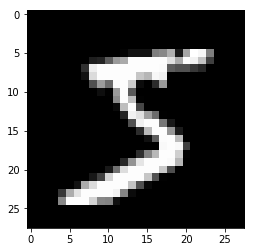

In [15]:
# Visualizamos la primera imagen del dataset
first_image = x_train_orig[0]
first_image = np.array(first_image, dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [16]:
# Comprobación del tamaño de la imagen
x_train_orig[0].shape

(28, 28)

A continuación implementaremos una red neuronal convolucional de una capa y haremos el entrenamiento y test sobre el dataset MNIST. Tenemos 60.000 imágenes para entrenar y 10.000 para testear. 

# 2. Pre-procesado de datos

El primer paso para entrenar una red neuronal consiste en pre-procesar los datos de entrenamiento y test.

In [17]:
# Tamaño de los datos originales
print("Tamaño de los datos originales de train: {}".format(x_train_orig.shape))
print("Tamaño de los datos originales de test : {}".format(x_test_orig.shape))

Tamaño de los datos originales de train: (60000, 28, 28)
Tamaño de los datos originales de test : (10000, 28, 28)


Seguidamente, aplicaremos una simple normalización de los datos para que queden comprendidos entre el rango 0 y 1. Aunque existen clases para aplicar la normalización, aquí emplearemos el método más simple, que es dividir los valores por el máximo para obtener valores en el rango entre 0 y 1.

In [18]:
print("Los valores del primer registro son: {}".format(x_train_orig[0,:,:]))

# Determinar valores mínimo y máximo para la normalización
v_min = np.min(x_train_orig)
v_max = np.max(x_train_orig)
print("Los valores mínimo y máximo son {} y {}.".format(v_min, v_max))

# Normalización entre 0 y 1
x_train_orig = (x_train_orig - v_min) / (v_max - v_min)
x_test_orig = (x_test_orig - v_min) / (v_max - v_min)

print("Los valores del primer registro después de la normalización son: {}".format(x_train_orig[0,:,:]))

Los valores del primer registro son: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0  

A continuación, ajustaremos el tamaño de los datos de entrenamiento y test utilizando 4 dimensiones, ya que la última dimensión debe ser 1 para indicar que las imágenes están en escala de grises.

In [19]:
x_train = x_train_orig.reshape(60000,28,28,1)
x_test = x_test_orig.reshape(10000,28,28,1)

print("Tamaño de los datos de train: {}".format(x_train.shape))
print("Tamaño de los datos de test : {}".format(x_test.shape))

Tamaño de los datos de train: (60000, 28, 28, 1)
Tamaño de los datos de test : (10000, 28, 28, 1)


Finalemte, codificaremos los valores de las etiquetas de salida en un vector `one-hot`. El objetivo de esta acción es convertir los datos al mismo formato que tendrá la salida de la red neuronal. Por ejemplo, el vector de salida para una imagen que contiene un 5 sería: [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]. 

Para realizar esta tarea de forma sencilla, se puede utilizar la función `to_categorical` de `Keras.utils`. 

In [20]:
y_train = to_categorical(y_train_orig)
y_test = to_categorical(y_test_orig)

print("El tamaño de y_train_orig es {} y el valor de y_train_orig[0] es {}".format(y_train_orig.shape, y_train_orig[0]))
print("El tamaño de y_train es {} y el valor de y_train[0] es {}".format(y_train.shape, y_train[0]))

El tamaño de y_train_orig es (60000,) y el valor de y_train_orig[0] es 5
El tamaño de y_train es (60000, 10) y el valor de y_train[0] es [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# 3. Creación del modelo

Vamos a usar un modelo `Secuencial` de Keras, ya que es muy intuitivo y fácil de utilizar. Este tipo de modelos nos permiten construir el modelo capa a capa. En concreto:

- La primera capa que añadiremos será una capa convolucional con las siguientes propiedades: 
    - Número de kernels (neuronas) primera capa: 64 neuronas
    - Tamaño de los kernels: 3x3
    - Activacion de los kernels: ReLU
- A continuación añadiremos una capa *Flatten* para conectar la salida de la capa convolucional con la entrada de una capa densa.
- Por último, añadiremos una capa densa de salida, y por lo tanto tendrá tantas neuronas como clases queremos predecir. La activación de esta última capa sera *Softmax*. La predicción final del modelo será entonces la clase que tenga una probabilidad más alta. 

El siguiente código implementa el modelo anterior, teniendo en cuenta que la salida de la red neuronal será un vector de probabilidades de las 10 clases anteriormente comentadas, i.e. 0...9.

In [21]:
# Número de clases
num_classes = 10

model = Sequential()

# Añadir las capas indicadas
model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(28,28,1)))
model.add(Flatten())
model.add(Dense(num_classes, activation="softmax"))

# 4. Compilación el modelo

Una vez definido el modelo, se debe compilar de forma previa al proceso de entrenamiento. Para ello vamos a utilizar el algoritmo de optimización `Adam`, la función de coste `categorical_crossentropy` y la métrica `accuracy`.

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 5. Entrenamiento del modelo

En este punto ya podemos entrenar el modelo. Haremos que el modelo vea cada imagen 10 veces diferentes (es decir, `epochs`=10), fijaremos un valor de `bacth` igual a 128 y utilizaremos el conjunto de test para la validación del proceso.

In [23]:
# Entrenamiento del modelo
n_epochs = 10
mfit = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=n_epochs)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 21s 352us/step - loss: 0.2301 - acc: 0.9349 - val_loss: 0.0895 - val_acc: 0.9746
Epoch 2/10
60000/60000 [==============================] - 20s 340us/step - loss: 0.0745 - acc: 0.9789 - val_loss: 0.0666 - val_acc: 0.9788
Epoch 3/10
60000/60000 [==============================] - 20s 341us/step - loss: 0.0530 - acc: 0.9843 - val_loss: 0.0644 - val_acc: 0.9808
Epoch 4/10
60000/60000 [==============================] - 20s 337us/step - loss: 0.0398 - acc: 0.9884 - val_loss: 0.0590 - val_acc: 0.9815
Epoch 5/10
60000/60000 [==============================] - 20s 332us/step - loss: 0.0324 - acc: 0.9904 - val_loss: 0.0641 - val_acc: 0.9810
Epoch 6/10
60000/60000 [==============================] - 20s 334us/step - loss: 0.0253 - acc: 0.9927 - val_loss: 0.0599 - val_acc: 0.9822
Epoch 7/10
60000/60000 [==============================] - 20s 334us/step - loss: 0.0209 - acc: 0.9937 - val_loss: 0.

# 6. Evolución de la precisión

A continuación, vamos a crear una función que nos permitirá ver la evolución de la *accuracy* y el *loss* en el conjunto de entrenamiento y test en función de las diferentes épocas (*epochs*) del entrenamiento.

In [24]:
# Plot del training loss y el accuracy
def plot_prediction(n_epochs, mfit):
    N = n_epochs
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    fig.suptitle('Training Loss and Accuracy')
    
    ax1.plot(np.arange(0, N), mfit.history["acc"], label="train")
    ax1.plot(np.arange(0, N), mfit.history["val_acc"], label="val")
    ax1.set_title("Accuracy")
    ax1.set_xlabel("Epoch #")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")
    
    ax2.plot(np.arange(0, N), mfit.history["loss"], label="train")
    ax2.plot(np.arange(0, N), mfit.history["val_loss"], label="val")
    ax2.set_title("Loss")
    ax2.set_xlabel("Epoch #")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")
    
    plt.show()

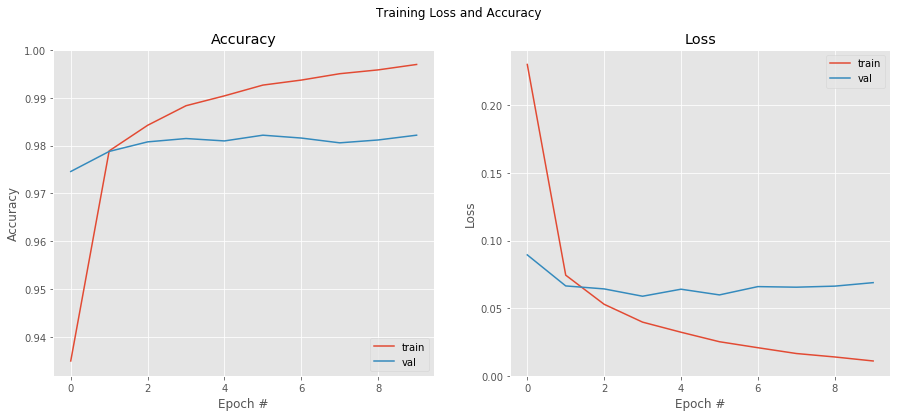

In [25]:
plot_prediction(n_epochs, mfit)

# 7. Predicción

Finalmente, podemos hacer la predicción para cuatro de las imágenes del conjunto de test y mirar si los resultados son o no correctos.

In [26]:
# Hacemos la predicción para las 4 primeras imágenes del set de test
print(model.predict(x_test[:4]))

# Mostramos el ground truth para las primeras 4 imágenes
y_test[:4]

[[8.2632358e-15 1.7160427e-13 8.1686040e-11 1.2636316e-07 1.1634286e-14
  1.2490455e-11 2.0120201e-21 9.9999988e-01 9.8667619e-10 2.8979748e-08]
 [2.1876938e-12 3.9645126e-10 1.0000000e+00 2.2406696e-10 5.2389698e-21
  8.3534967e-12 5.0966094e-09 8.2585351e-24 4.5951576e-12 4.0705124e-18]
 [8.1125017e-07 9.9986017e-01 8.5136953e-06 7.8809576e-10 8.2128281e-05
  1.7081739e-07 1.6878213e-08 2.0577497e-06 4.6190904e-05 1.9631039e-09]
 [9.9999964e-01 1.5076602e-10 5.8781914e-08 1.2309736e-11 4.1053865e-11
  2.4673852e-09 3.2722198e-07 4.7614370e-09 3.4281467e-10 3.0139938e-10]]


array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])